In [24]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from copy import deepcopy
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from torchvision import datasets, models
import torch.optim as optim
from torch.utils.data import random_split, Dataset
from torchvision import datasets, transforms
from dataset_wrappers import TransformedDataset

In [7]:
def load_animals_pictures(data_dir="./raw-img", train_ratio=0.8):
    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel"
    }
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    old_classes = dataset.classes
    new_classes = [translate[c] for c in old_classes]
    dataset.classes = new_classes

    dataset.class_to_idx = {
        translate[k]: v for k, v in dataset.class_to_idx.items()
    }

    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    test_size = dataset_size - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

In [8]:
try:
    train_dataset, test_dataset = load_animals_pictures()
    print("Data successfully downloaded and unpacked!")
    print(f"Training set size: {len(train_dataset)} images")
    print(f"Test set size: {len(test_dataset)} images")
except Exception as e:
    print(f"Data loading error: {e}")

Data successfully downloaded and unpacked!
Training set size: 20943 images
Test set size: 5236 images


In [9]:
val_size = int(len(train_dataset) * 0.2)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

In [10]:
transform_train_data = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    #transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    #transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=10),
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    #transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    #transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2.0)),
    #transforms.RandomSolarize(threshold=192, p=0.2),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
])

In [11]:
batch_size = 32

In [12]:
transformed_train_dataset = TransformedDataset(train_ds, transform_train_data)
transformed_val_dataset = TransformedDataset(val_ds)
transformed_test_dataset = TransformedDataset(test_dataset)

train_DataLoader = DataLoader(transformed_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_DataLoader = DataLoader(transformed_val_dataset, batch_size=batch_size*2, num_workers=2, pin_memory=True)
test_DataLoader = DataLoader(transformed_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
def display_metrics(model, test_loader, title="Confusion Matrix"):
    model.eval()
    y_true = []
    y_pred = []

    device = next(model.parameters()).device
        
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(predicted.detach().cpu().numpy())

    targ_names = test_loader.dataset.dataset.classes
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", 
                    xticklabels=targ_names, 
                    yticklabels=targ_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()
        
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=targ_names))

In [44]:
def train_one_epoch(model, train_loader, optimizer, loss_function):
    model.train()
    running_loss = 0.0
    total_samples  = 0
    y_true = []
    y_pred = []

    device = next(model.parameters()).device
        
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    train_loss = running_loss / total_samples
    
    return train_loss, y_true, y_pred

In [45]:
def evaluate_one_epoch(model, val_loader, loss_function):
    model.eval()
    running_vloss = 0.0
    total_samples = 0
    y_true = []
    y_pred = []

    device = next(model.parameters()).device
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            vloss = loss_function(outputs, labels)

            batch_size = images.size(0)
            running_vloss += vloss.item() * batch_size
            total_samples += batch_size
            
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    val_loss = running_vloss / total_samples
    
    return val_loss, y_true, y_pred

In [46]:
class EarlyStopping:
    def __init__(self, patience=10, mode="min", delta=0.0, save_path="best_model.pt"):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_metric = np.inf if mode == "min" else -np.inf
        self.delta = delta
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, current_metric, model) -> bool:
        if self.mode == "min":
            improved = current_metric < (self.best_metric - self.delta)
        else:
            improved = current_metric > (self.best_metric + self.delta)

        if improved:
            print(f"Metric improved ({self.best_metric:.6f} → {current_metric:.6f}).  Saving model.")
            self.best_metric = current_metric
            torch.save(model.state_dict(), self.save_path)
            self.counter = 0
        else:
            self.counter += 1
            print(f"Early Stopping Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True

        return self.early_stop

    def get_metric(self, val_loss, f1_score):
        mode = self.mode
        metric = val_loss if mode == "min" else f1_score
        return metric

In [47]:
def unfreeze_layers(model, epoch):
    if epoch == 1:
        for param in model.layer4.parameters():
            param.requires_grad = True
        print("Unfreeze layer4")
    elif epoch == 2:
        for param in model.layer3.parameters():
            param.requires_grad = True
        print("Unfreeze layer3")
    elif epoch == 3:
        for param in model.layer2.parameters():
            param.requires_grad = True
        print("Unfreeze layer2")
    elif epoch == 4:
        for param in model.layer1.parameters():
            param.requires_grad = True
        print("Unfreeze layer1")

In [48]:
def train(model, train_loader, validation_loader, optimizer, loss_function, early_stopper, scheduler=None, epochs=5):    
    loss_dict = {"train": [], "val": []}
    acc_dict = {"train": [], "val": []}
    f1_dict = {"train": [], "val": []}
    
    for epoch in range(1, epochs+1):
        unfreeze_layers(model, epoch)
        
        train_loss, train_true, train_pred = train_one_epoch(model, train_loader, optimizer, loss_function)
        val_loss, val_true, val_pred = evaluate_one_epoch(model, validation_loader, loss_function)
    
        results = {
            "train": (train_loss, train_true, train_pred),
            "val":   (val_loss,   val_true,   val_pred)
        }
        
        for phase, (loss, y_true, y_pred) in results.items():
            loss_dict[phase].append(loss)
            acc_dict[phase].append(accuracy_score(y_true, y_pred))
            f1_dict[phase].append(f1_score(y_true, y_pred, average="macro"))
        
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
            current_lr = optimizer.param_groups[0]["lr"]
            print(f"LR: {current_lr:.6f}")
            
            if current_lr < 1e-7:
                print("Learning rate too low, stopping early!")
                break

        metric = early_stopper.get_metric(val_loss, f1_dict["val"][-1])
        if early_stopper(metric, model):
            break

    return loss_dict, acc_dict, f1_dict

In [16]:
num_classes = len(train_dataset.dataset.classes)
num_classes

10

In [17]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\milit/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:09<00:00, 10.7MB/s]


In [18]:
model.fc.in_features

2048

In [19]:
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [21]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.fc.parameters():
    param.requires_grad = True

In [30]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)
early_stopper = EarlyStopping(patience=15, mode="max", delta=1e-7)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3, factor=0.35)

loss_dict, acc_dict, f1_dict = train(model=model, 
                                     train_loader=train_DataLoader, 
                                     validation_loader=val_DataLoader, 
                                     loss_function=loss_function,
                                     early_stopper=early_stopper,
                                     optimizer=optimizer,
                                     scheduler=scheduler,
                                     epochs=25)

Epoch 1/25, Train Loss: 0.5217, Validation Loss: 0.1866
LR: 0.001000
Metric improved (-inf → 0.955543).  Saving model.
Epoch 2/25, Train Loss: 0.2611, Validation Loss: 0.1438
LR: 0.001000
Metric improved (0.955543 → 0.961944).  Saving model.
Epoch 3/25, Train Loss: 0.2255, Validation Loss: 0.1254
LR: 0.001000
Metric improved (0.961944 → 0.964879).  Saving model.
Epoch 4/25, Train Loss: 0.2004, Validation Loss: 0.1669
LR: 0.001000
Early Stopping Counter: 1/15
Epoch 5/25, Train Loss: 0.1919, Validation Loss: 0.1414
LR: 0.001000
Early Stopping Counter: 2/15
Epoch 6/25, Train Loss: 0.1867, Validation Loss: 0.2035
LR: 0.001000
Early Stopping Counter: 3/15
Epoch 7/25, Train Loss: 0.1737, Validation Loss: 0.1305
LR: 0.000350
Early Stopping Counter: 4/15
Epoch 8/25, Train Loss: 0.1667, Validation Loss: 0.1138
LR: 0.000350
Metric improved (0.964879 → 0.966532).  Saving model.
Epoch 9/25, Train Loss: 0.1613, Validation Loss: 0.1316
LR: 0.000350
Early Stopping Counter: 1/15
Epoch 10/25, Train Los

In [31]:
checkpoint = torch.load("best_model.pt", map_location=device)
model.load_state_dict(checkpoint)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

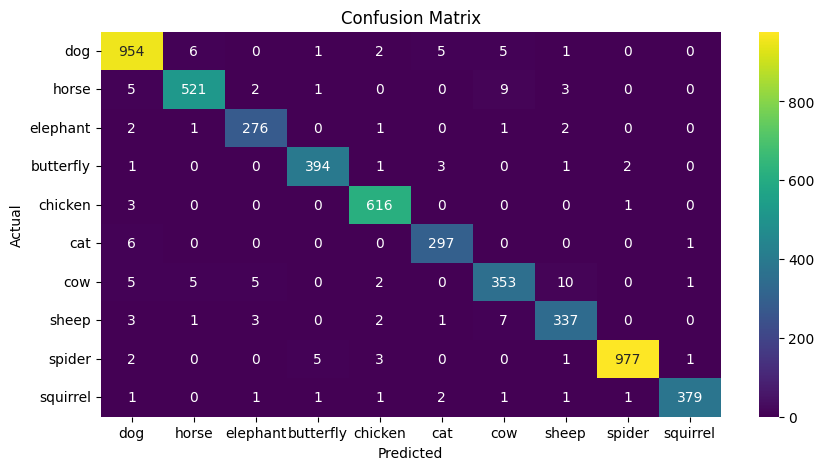


Classification Report:
              precision    recall  f1-score   support

         dog       0.97      0.98      0.98       974
       horse       0.98      0.96      0.97       541
    elephant       0.96      0.98      0.97       283
   butterfly       0.98      0.98      0.98       402
     chicken       0.98      0.99      0.99       620
         cat       0.96      0.98      0.97       304
         cow       0.94      0.93      0.93       381
       sheep       0.95      0.95      0.95       354
      spider       1.00      0.99      0.99       989
    squirrel       0.99      0.98      0.98       388

    accuracy                           0.97      5236
   macro avg       0.97      0.97      0.97      5236
weighted avg       0.97      0.97      0.97      5236



In [33]:
display_metrics(model, test_DataLoader)

In [37]:
def denormalize(image):
    return image * 0.5 + 0.5

In [42]:
def visualize_incorrect_predictions(model, test_loader, num_images=8):
    model.eval()
    wrong_images = []
    wrong_labels = []
    wrong_preds  = []
    classes = test_loader.dataset.dataset.classes

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            mask = preds != labels
            if mask.any():
                idxs = mask.nonzero(as_tuple=True)[0]
                for idx in idxs:
                    wrong_images.append(images[idx].cpu().numpy())
                    wrong_labels.append(labels[idx].cpu().item())
                    wrong_preds.append(preds[idx].cpu().item())
                    if len(wrong_images) >= num_images:
                        break
            if len(wrong_images) >= num_images:
                break

    if len(wrong_images) == 0:
        print("No incorrect predictions found in the test set.")
        return

    imgs = np.stack(wrong_images, axis=0)
    imgs = denormalize(imgs)

    cols = min(4, num_images)
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(imgs):
            img = np.transpose(imgs[i], (1, 2, 0))
            ax.imshow(img)
            ax.set_title(f"True: {classes[wrong_labels[i]]}\nPred: {classes[wrong_preds[i]]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

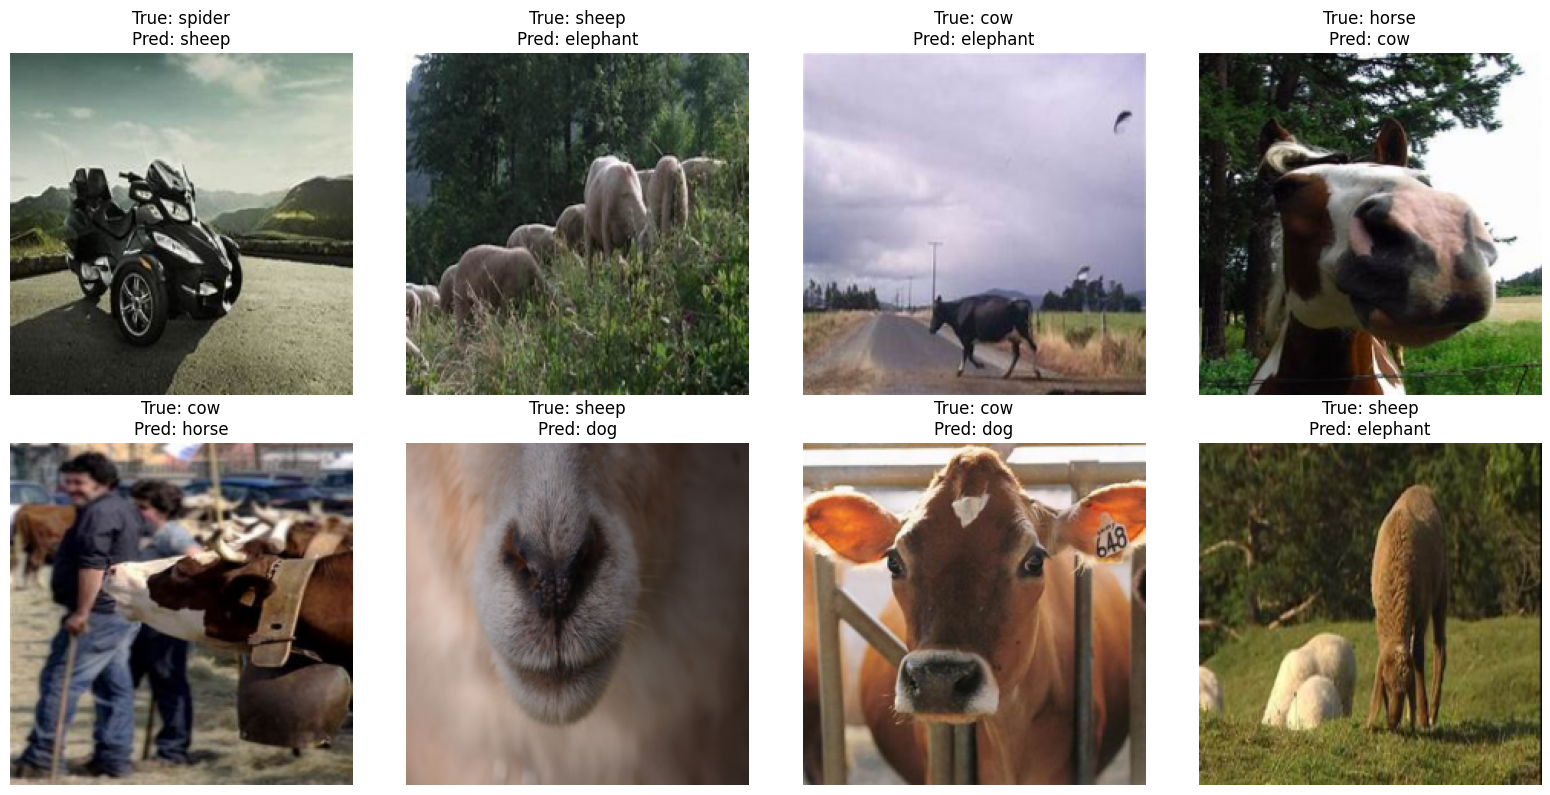

In [43]:
visualize_incorrect_predictions(model, test_DataLoader)